# Projekt 3 - Eksperymenty i analiza danych
## Autorzy
- Daniel Zdancewicz [145317]
- Alex Terentowicz [145419]

## Opis

Projekt polega na przeprowadzeniu eksperymentów z użyciem kilku metod i przeprowadzeniu analizy uzyskanych wyników.
Należało odnaleźć zbiór danych, który zawiera kilka kryteriów monotonicznych, ponad 100 alternatyw i co najmniej 2 klasy (jeśli problem ma więcej klas, możesz je zbinaryzować).

Krótko opisz zbiór danych, w tym opisy kryteriów. Dla tego zbioru danych wytrenuj następujące modele:
- Jeden prosty, interpretowalny model ML (np. XGBoost, rankSVM lub regresja logistyczna)
- Jeden interpretowalny model ANN-MCDA przedstawiony na zajęciach (ANN-Ch-Constr. lub ANN-UTADIS)
- Złożony model sici neuronowej zawierającej kilka warstw ukrytych.


## Opis zbioru danych

W tej pracy wybrany zbiór zawierający dane o udzielonych kredytach. Zbiór zawiera 614 rekordów, 13 kolumn i 2 klasy. Kolumny to:
- Loan_ID — Identyfikator udzielonego kredytu
- Gender — Płeć kredytobiorcy
- Married — Stan cywilny kredytobiorcy
- Dependents — Liczba osób na utrzymaniu kredytobiorcy
- Education — Wykształcenie kredytobiorcy
- Self_Employed — Czy kredytobiorca jest samozatrudniony
- ApplicantIncome — Miesięczny dochód kredytobiorcy
- CoapplicantIncome — Miesięczny dochód współkredytobiorcy
- LoanAmount — Kwota kredytu
- Loan_Amount_Term — Okres spłaty kredytu w miesiącach
- Credit_History — Historia kredytowa kredytobiorcy
- Property_Area — Lokalizacja nieruchomości kredytobiorcy
- Loan_Status — Czy kredyt został spłacony

Źródło danych — [Kaggle](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset)

Jako kryteria monotoniczne wybrano:
- ApplicantIncome
- CoapplicantIncome
- LoanAmount
- Loan_Amount_Term

Jako kryteria niemonotoniczne wybrano:
- Gender
- Married
- Dependents
- Education
- Self_Employed
- Credit_History
- Property_Area

Jako klasy wybrano kolumnę Loan_Status, która zawiera informacje o tym czy kredyt został spłacony:
- Y — Kredyt został spłacony
- N — Kredyt nie został spłacony



## Preprocessing

In [117]:
from numpy._typing import NDArray
from typing import ClassVar
from sklearn.preprocessing import OneHotEncoder
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from pandas import DataFrame

@dataclass
class Dataset(object):
  train: DataFrame
  test: DataFrame
  _encoder: ClassVar[OneHotEncoder] = OneHotEncoder(handle_unknown='ignore')

  @classmethod
  def load(cls):
    return cls(
      pd.read_csv(f"./resources/datasets/loan_sanction_train.csv"),
      pd.read_csv(f"./resources/datasets/loan_sanction_test.csv")
    )

  def preprocess(self, split: str = 'train') -> tuple[NDArray, NDArray | None]:
    if split == 'train':
      df = self.train.copy()
      df.dropna(inplace=True)
      df.drop(columns=["Loan_ID"], inplace=True)

      X = df.drop(columns=["Loan_Status"])
      y = df["Loan_Status"]

      X = self._encoder.fit_transform(X)
      y = y.map({"N": 0, "Y": 1})

      return X, y
    df = self.test.copy()
    df.dropna(inplace=True)

    df.drop(columns=["Loan_ID"], inplace=True)
    X = self._encoder.transform(df)

    return X


In [119]:
ds = Dataset.load()

ds.train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [89]:
ds.train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Trening modeli

### LogisticRegression — interpretowalny model ML

In [120]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
  ("model", LogisticRegression())
])

(X, y) = ds.preprocess('train')

gcv = GridSearchCV(pipeline, {}, scoring={
  'accuracy': 'accuracy',
  'f1': 'f1',
  'roc_auc': 'roc_auc'
}, refit='accuracy', cv=10, n_jobs=-1, verbose=1)

gcv.fit(X, y)

print(gcv.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
0.8083333333333332


In [ ]:
X = ds.preprocess('test')

probabilities = gcv.predict_proba(X)
predictions = gcv.predict(X)

In [ ]:
probabilities

In [ ]:
gcv.best_score_

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_12712\3009636022.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ds.train.corr(), annot=True)


<Axes: >

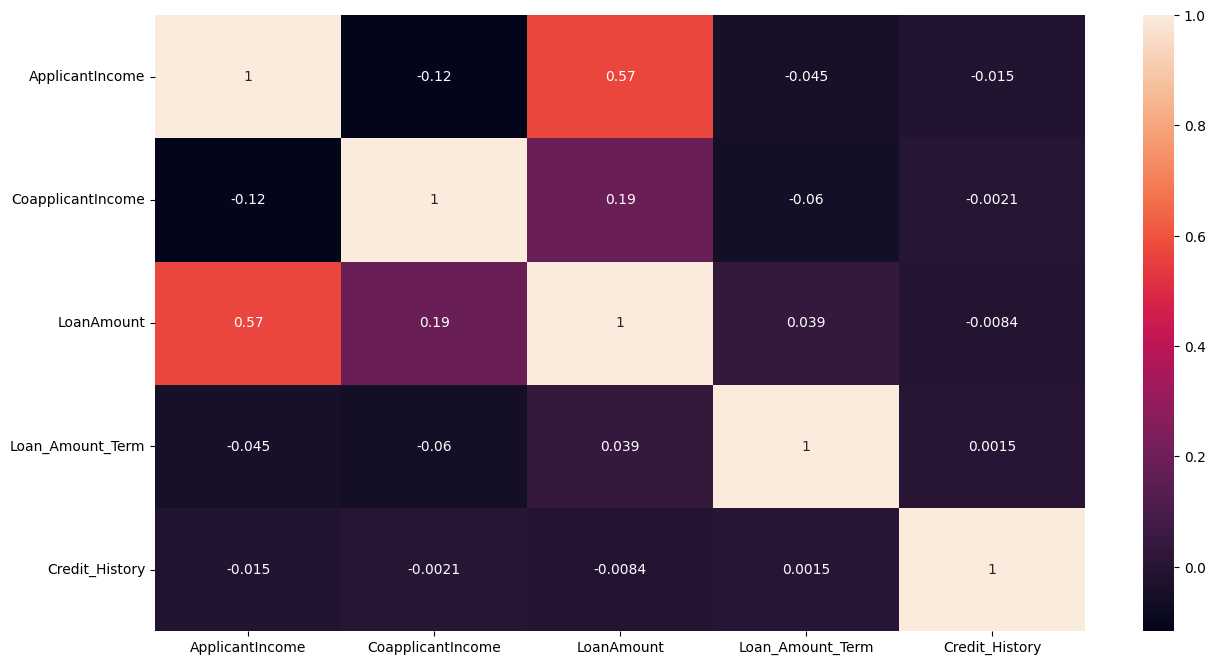

In [121]:
import seaborn as sns

plt.figure(figsize=[15, 8])
sns.heatmap(ds.train.corr(), annot=True)

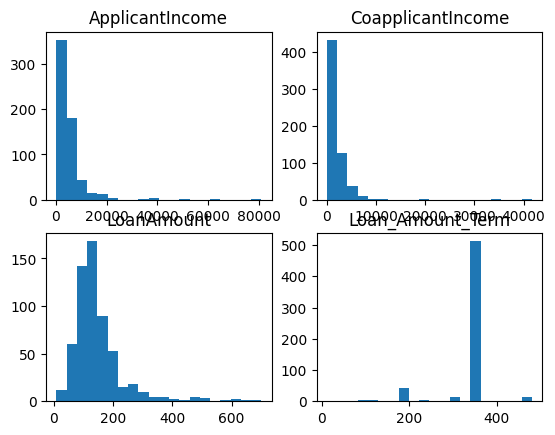

In [123]:
fig, axs = plt.subplots(2, 2)
params = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]

for i, param in enumerate(params):
  axs[i // 2, i % 2].hist(ds.train[param], bins=20)
  axs[i // 2, i % 2].set_title(param)


### ANN-Ch-Constr. — interpretowalny model ANN-MCDA

### Głęboka sieć neuronowa — model złożony.

## Eksperymenty
Wszystkie prezentowane wartości są do maksymalnie 4 miejsc po przecinku.

### Przedstawienie metryk

- Rank SVM
    - Accuracy
    - F1
    - AUC
- ANN-Ch-Constr.
    - Accuracy
    - F1
    - AUC
- Głęboka sieć neuronowa
    - Accuracy
    - F1
    - AUC


### Przedstawienie modelu
(np funkcje cząstkowe, schemat drzewa ...).


### Interpretacja
- Czy na podstawie uzyskanych parametrów możemy powiedzieć coś o preferencjach
użytkowników?
- Czy są jakieś kryteria, które nie mają żadnego wpływu, czy też mają wpływ decydujący.
- Czy istnieją jakieś progi preferencji?
- Czy istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji?


### Interpretacja techniką Partial Dependence Plot
Wykonaj interpretację modelu korzystając z conajmniej jednej techniki( Global Surrogate,
Partial Dependence Plot Permutation Feature Importance ...)


Dla 3 wybranych wariantów dokonaj wyjaśnienia decyzji.
- Znajdź minimalną zmianę w ocenach tak aby wariant został przypisany do innej klasy.
    – Spróbuj odpowiedzieć na to pytanie w sposób analityczny, opierając się tylko na
wartościach parametrów modelu i wyjaśnij, dlaczego taka zmiana jest minimalna
(bez próbkowania).
    - Wykonaj próbkowanie przestrzeni, nieznacznie zmieniając oceny, tak aby uzyskać
inną klasę. Czy wyniki zgadzają się z przewidywaniami teoretycznymi?
- Dokonaj wyjaśnienia predykcji za pomocą conajmniej jednej techniki (Anchors LIME,
SHAP, ... )


##### Możliwe narzędzia
Lista narzędzi, które zawierają różne techniki wyjaśniania predykcji i interpretacji modelu:
- Shapash
- Alibi
- Explainerdashboard
- DALEX
- eli5
- aix360#%%
